In [11]:
#%% (0) Important libraries
import tensorflow as tf
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import Input
from keras import Model
import keras.backend as K
from functools import partial
from keras.regularizers import l1,l2

from keras import optimizers
from IPython import display
% matplotlib inline

In [ ]:
print(tf.__version__)

## MS - RNN models

In [90]:
# the conditional density function, conditioned on state

def cond_density(x,y,s,theta):
    
    sigma= theta['sigma'][s]
    length = np.int(len(theta['phi'])/2)
    phi=np.array(theta['phi'])[s*length:((s+1)*length)]
    mu= theta['mu'][s]
    ret=np.exp(-0.5*np.log(2*np.pi) -0.5*np.log(sigma**2) -0.5*(y-np.dot(x,phi) -mu)**2/sigma**2)
    #print(ret)
    return(ret)

In [91]:
# generate the data

def generate_vol_sample(length, sigma_0, n_steps, step_size, p, eps=0.01, shift=0):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    phi = np.array([0]*length*p, dtype='float64').reshape(length,p)
    #phi2 = np.array([0]*length, dtype='float64')
    step_length=100 #np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      #mu[i*step_length:((i*step_length)+1)]=step_size #*(-1)**i
      mu[i*step_length:((i+1)*step_length)]= step_size*(-1)**i
      if i%2==0:  
        phi[i*step_length:((i+1)*step_length),:]= 0.05
        #phi2[i*step_length:((i+1)*step_length)]=1.0
      else:
        phi[i*step_length:((i+1)*step_length),:]=0.01
        #phi2[i*step_length:((i+1)*step_length)]=0.5
    for i in range(p, length):
        sigma[i]= mu[i-1] + random.normal(0,eps)
        for j in range(p):
          sigma[i]+=phi[i-1,j]*sigma[i-j]  
        
    return (sigma+shift)

In [65]:
p = 30 # the number of lags (in both the data and the models)
data=generate_vol_sample(3000, 0.25, 15, 0.1, p, 1e-4, 0.13)
T= 1000 # number of training sample
ts=data[:T] # training set
vs=data[T:2*T] # verification set (for tuning)
tts=data[2*T:] # testing set
split = T

In [92]:
# initialization of parameters for EM algorithm

def init_theta():
    
    
    theta = {}
    theta['mu']= [0.1,-0.1] #[-0.2+ 0.4*np.random.rand(1),-0.2+ 0.4*np.random.rand(1)] # [0.1,-0.1]
    theta['phi'] = []
    for j in range(p):
      theta['phi'].append(0.05)
      #theta['phi'].append(0.03)
      #theta['phi'].append(-0.1+ +0.2*np.random.rand(1)) #1+(0.03-0.01)*np.random.rand(1))
    for j in range(p):
      theta['phi'].append(0.01)
      #theta['phi'].append(0.02)
      #theta['phi'].append(-0.1+ 0.2*np.random.rand(1))# 2*np.random.rand(1))  
    
    
    p11=0.95
    p00=0.95

    p0=(1-p11)/(2-p00-p11)
    p1=(1-p00)/(2-p00-p11)
    p10=1-p00
    p01=1-p11

    theta['sigma']=[1e-2, 1e-2]
    theta['p']=[p0,p1]
    theta['P']=[p00,p01,p10,p11]
    
    return(theta)

In [68]:
def e_step(ts, theta, p=30): # expectation step
    T = len(ts)
    y = np.array([0]*T, dtype='float64')
    y[0:(T-1)]=ts[1:T]
    y[T-1]=ts[T-1]
    
    x=ts[0:T]
    
    p_filter_0=np.array([0]*T, dtype='float64') # filtering probability conditioned on state 0
    p_filter_1=np.array([0]*T, dtype='float64') # filtering probability conditioned on state 1
    pp_filter_0=np.array([0]*T, dtype='float64')# predictive probability conditioned on state 0
    pp_filter_1=np.array([0]*T, dtype='float64')# predictive probability conditioned on state 1
    sp_filter_0=np.array([0]*T, dtype='float64')# smoothing probability conditioned on state 0
    sp_filter_1=np.array([0]*T, dtype='float64')# smoothing probability conditioned on state 1

    cpdf_0=np.array([0]*T, dtype='float64') # conditional pdf for state 0
    cpdf_1=np.array([0]*T, dtype='float64') # conditional pdf for state 1
    
    p0 = theta['p'][0] # initial state probability for state 0
    p1 = theta['p'][1] # initial state probability for state 0
    p00 = theta['P'][0] # transistion probability
    p01 = theta['P'][1] # transistion probability
    p10 = theta['P'][2] # transistion probability
    p11 = theta['P'][3] # transistion probability
    pp_filter_0[p]=p0   # Initialize predictive probability
    pp_filter_1[p]=p1   # Initialize predictive probability
    
    for t in range(p,T):
        
        cpdf_0[t]=cond_density(x[t:(t-p):-1],y[t],0,theta)
        cpdf_1[t]=cond_density(x[t:(t-p):-1],y[t],1,theta)
        marginal=pp_filter_0[t]*cpdf_0[t] + pp_filter_1[t]*cpdf_1[t]
        #print(marginal)
        p_filter_0[t]=pp_filter_0[t]*cpdf_0[t]/(marginal) # compute the filtering probability (state 0)
        p_filter_1[t]=pp_filter_1[t]*cpdf_1[t]/(marginal) # compute the filtering probability (state 1)
        if t<(T-1):
            pp_filter_0[t+1]=p00*p_filter_0[t] + p10*p_filter_1[t] # update the predictive probabilities
            pp_filter_1[t+1]=p01*p_filter_0[t] + p11*p_filter_1[t]
            


    sp_filter_0[T-1]=p_filter_0[T-1]
    sp_filter_1[T-1]=p_filter_1[T-1]

    for t in range(T-2,p,-1):
        sp_filter_0[t]=p_filter_0[t]*(p00*p_filter_0[t+1]/(pp_filter_0[t+1]) + p01*p_filter_1[t+1]/(pp_filter_1[t+1]))
        sp_filter_1[t]=p_filter_1[t]*(p10*p_filter_0[t+1]/(pp_filter_0[t+1]) + p11*p_filter_1[t+1]/(pp_filter_1[t+1]))
    
    res= {}
    res['smoothing'] = []
    res['smoothing'].append(sp_filter_0)
    res['smoothing'].append(sp_filter_1)
    res['filtering'] = []
    res['filtering'].append(p_filter_0)
    res['filtering'].append(p_filter_1)
    res['predictive'] = []
    res['predictive'].append(pp_filter_0)
    res['predictive'].append(pp_filter_1)
   
     
    return(res)

In [93]:
x=ts[0:T] # set up a data structure for the MS-AR(p) model
X= np.array([0]*(T-p)*p, dtype='float64').reshape(T-p,p)
for t in range(T-p):
    X[t,:]= x[t+p:t:-1]


In [95]:
def m_step(ts, res, theta, p=30): # M-step
    T = len(ts)
    y = np.array([0]*T, dtype='float64')
    e0 = np.array([0]*T, dtype='float64')
    e1 = np.array([0]*T, dtype='float64')
    
    y[0:(T-1)]=ts[1:T]
    y[T-1]=ts[T-1]
    
    x=ts[0:T]
    
    mu0= theta['mu'][0]
    mu1= theta['mu'][1]
    
    length = np.int(len(theta['phi'])/2)
    phi0=np.array(theta['phi'], dtype='float64')[:length]
    phi1=np.array(theta['phi'], dtype='float64')[length:(2*length)]
    
    sigma0=theta['sigma'][0]
    sigma1=theta['sigma'][1]
    
    
    p0 = theta['p'][0]
    p1 = theta['p'][1]
    p00 = theta['P'][0]
    p01 = theta['P'][1]
    p10 = theta['P'][2]
    p11 = theta['P'][3]
    
    
    p00=np.sum(res['smoothing'][0][p:(T-1)]*p00)/(np.sum(res['smoothing'][0][p:(T-1)]))
    p11=np.sum(res['smoothing'][1][p:(T-1)]*p11)/(np.sum(res['smoothing'][1][p:(T-1)]))
    p01=np.sum(res['smoothing'][1][p:(T-1)]*p01)/(np.sum(res['smoothing'][1][p:(T-1)]))
    p10=np.sum(res['smoothing'][0][p:(T-1)]*p10)/(np.sum(res['smoothing'][0][p:(T-1)]))
    
    p0=(1-p11)/(2-p00-p11)
    p1=(1-p00)/(2-p00-p11)
    #print(res['smoothing'][0][p:(T-1)])
    
    mu0 = np.sum((y[p:T]-np.dot(X,phi0))*res['smoothing'][0][p:T])/(np.sum(res['smoothing'][0][p:T]))
    mu1 = np.sum((y[p:T]-np.dot(X,phi1))*res['smoothing'][1][p:T])/(np.sum(res['smoothing'][1][p:T]))
    #print(mu0,mu1)
    
    xp0= np.transpose(X)*res['smoothing'][0][p:T]
    xp1 =np.transpose(X)*res['smoothing'][1][p:T]
    A0 = np.dot(xp0,X)
    A1 = np.dot(xp1,X)
    
    b0 = np.dot(np.transpose(X), (y[p:T]-mu0)*res['smoothing'][0][p:T])
    b1 = np.dot(np.transpose(X), (y[p:T]-mu1)*res['smoothing'][1][p:T])
    
    phi0=np.dot(np.linalg.inv(A0),b0) #np.sum(x[t:(t-p):-1]*(y-mu0)*res['smoothing'][0])
    ###phi0 = np.sum(x*(y-mu0)*res['smoothing'][0])/np.sum(x*x*res['smoothing'][0])
    #A = np.sum(np.outer(x[t:(t-p):-1],x[t:(t-p):-1])*res['smoothing'][1])
    
    phi1=np.dot(np.linalg.inv(A1),b1)
    ####phi1 = np.sum(x*(y-mu1)*res['smoothing'][1])/np.sum(x*x*res['smoothing'][1])
    
    for t in range(p,T):
      e0[t]= y[t]-np.dot(phi0,x[t:(t-p):-1]) - mu0 # error (state 0)
      e1[t]= y[t]-np.dot(phi1,x[t:(t-p):-1]) - mu1 # error (state 1)
    
    #print(np.sum(e0), np.sum(e1),  np.sum(res['smoothing'][0][p:(T-1)]), np.sum(res['smoothing'][1][p:(T-1)]), np.sum(e0[p:(T-1)]**2*res['smoothing'][0][p:(T-1)]))
    sigma0=np.sqrt(np.sum(e0[p:(T-1)]**2*res['smoothing'][0][p:(T-1)])/(np.sum(res['smoothing'][0][p:(T-1)])))
    sigma1=np.sqrt(np.sum(e1[p:(T-1)]**2*res['smoothing'][1][p:(T-1)])/(np.sum(res['smoothing'][1][p:(T-1)])))
    
    theta['p']=[p0,p1]
    theta['P']=[p00,p01,p10,p11]
    theta['mu']=[mu0,mu1]
    theta['phi'][:p]=phi0
    theta['phi'][p:]=phi1
    
    theta['sigma']=[sigma0, sigma1]
    
    return(theta)

## Perform m iterations of E-M algorithm

In [86]:
eps = 1e-5 # tolerance
err = 2*eps
errs = np.array([0]*100, dtype='float64')

for j in range(1):
  theta_0=init_theta()
  theta=theta_0

  i = 0
  err_list =[]
  #probs=e_step(ts, theta)
  #m_step(ts, probs, theta)

  while (np.abs(err)>eps and i <1000):
    i+=1
    theta_list= []
    for key in theta.keys():
        #print(key, theta[key])
        theta_list += theta[key]
    #print(theta_list) 
    theta_p = np.array(theta_list)
    
    probs=e_step(ts, theta, p)
    #print(probs)
    theta=m_step(ts, probs, theta, p )
       
    theta_list= []
    
    for key in theta.keys():
        #print(key, theta[key])
        theta_list += theta[key]
    #print(theta_list)      
    err=np.linalg.norm(np.array(theta_list)-theta_p,2)
    err_list.append(err)
    print(i, err)
    
  errs[j]=np.abs(err)  
    

1 0.24733890464319022
2 0.0038616913654539076
3 0.002110837322188457
4 0.0016420106334174736
5 0.0015436955125629074
6 0.0015186834143081894
7 0.0015055382979449494
8 0.0014941584410914977
9 0.001483115220412327
10 0.001472193437699478
11 0.0014613587200401055
12 0.0014506053216584748
13 0.0014399307136323599
14 0.0014293346837560307
15 0.0014188169723170043
16 0.0014083764786212683
17 0.001398012947333611
18 0.001387725311957997
19 0.001377513842905628
20 0.0013673772421808218
21 0.0013573150841095032
22 0.001347327228194934
23 0.0013374130231255622
24 0.0013275714410371075
25 0.0013178025048613186
26 0.001308105095859431
27 0.0012984794774234597
28 0.0012889245364785763
29 0.001279439844626368
30 0.0012700246001493454
31 0.001260679625906717
32 0.0012514027605359912
33 0.0012421938376377044
34 0.0012330531775833278
35 0.0012239799490381545
36 0.0012149729312395077
37 0.0012060323361827816
38 0.0011971578077819218
39 0.0011883485348069052
40 0.0011796037251195332
41 0.0011709237692676

318 0.00015136258543266333
319 0.0001502491851759034
320 0.000149143652490195
321 0.00014804584975002474
322 0.0001469567086413348
323 0.0001458750146295037
324 0.00014480176375172054
325 0.00014373637850024365
326 0.00014267846579317812
327 0.0001416284656902136
328 0.0001405865067586605
329 0.0001395518232216318
330 0.00013852496018994644
331 0.00013750547924354056
332 0.00013649347971077076
333 0.00013548926693008026
334 0.00013449228661198577
335 0.00013350233064482881
336 0.0001325204047672513
337 0.00013154508382995454
338 0.0001305770337005379
339 0.00012961614221731785
340 0.00012866248233654146
341 0.00012771566171916151
342 0.00012677563302102224
343 0.00012584287253370133
344 0.00012491703054292856
345 0.00012399753236490274
346 0.00012308532003679412
347 0.00012217945679983042
348 0.0001212805168454915
349 0.00012038808785251762
350 0.00011950175679454014
351 0.00011862280032189497
352 0.00011774974164011634
353 0.00011688337190584023
354 0.00011602315828345951
355 0.000115

632 1.4887746617536164e-05
633 1.4778105926523627e-05
634 1.46695985044201e-05
635 1.4561482279323689e-05
636 1.4454332477362403e-05
637 1.4347904246921672e-05
638 1.4242749708017824e-05
639 1.413757406869172e-05
640 1.4033369135588859e-05
641 1.3930199082370193e-05
642 1.382776837545103e-05
643 1.3725888219812569e-05
644 1.362520370131398e-05
645 1.3524925903706245e-05
646 1.3425258331562975e-05
647 1.3326380311894603e-05
648 1.3228208076846903e-05
649 1.3131273497804895e-05
650 1.3034432359695949e-05
651 1.293850658473636e-05
652 1.2843393944448225e-05
653 1.2748652321685262e-05
654 1.2654821907378754e-05
655 1.256190387295521e-05
656 1.2469436388742537e-05
657 1.2377788166346043e-05
658 1.2286510562035874e-05
659 1.2196062790755607e-05
660 1.2106418944071492e-05
661 1.2017326854432853e-05
662 1.1929052254263307e-05
663 1.1841300010941182e-05
664 1.1754190178875106e-05
665 1.166755495615658e-05
666 1.158177823923237e-05
667 1.1496471576618766e-05
668 1.141179275169687e-05
669 1.13278

Text(0.5,0,'r')

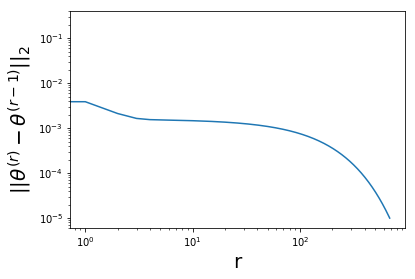

In [88]:
plt.loglog(err_list)
plt.ylabel("$||\\theta^{(r)}-\\theta^{(r-1)}||_2$", fontsize=20)
plt.xlabel("r", fontsize=20)

Text(0,0.5,'Pr$(s_t=0\\ |\\ \\mathcal{F}_T)$')

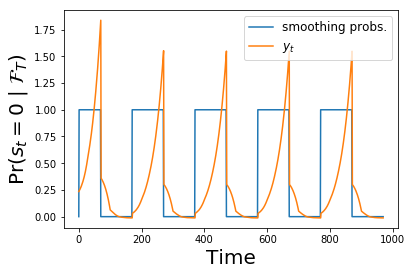

In [89]:
plt.plot(probs['smoothing'][0][p:T], label="smoothing probs.")
plt.plot(data[30:T], label="$y_t$")

plt.legend(loc="best", fontsize=12)
#plt.title('Smoothing probabilities', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Pr$(s_t=0\ |\ \mathcal{F}_T)$', fontsize=20)


# Generate the in-sample predictions with AR (for testing purposes only)

In [75]:
T = len(ts)
Tv = len(vs)
Tt = len(tts)
y = np.array([0]*(T+Tv+Tt), dtype='float64')
y_hat = np.array([0]*(T+Tv+Tt), dtype='float64')

y[0:(T+Tv+Tt-1)]=data[1:(T+Tv+Tt)]
y[T+Tv+Tt-1]=data[T+Tv+Tt-1]
    
x=data

mu0= theta['mu'][0]
mu1= theta['mu'][1]
phi0=theta['phi'][:p]
phi1=theta['phi'][p:]

p00 = theta['P'][0]
p01 = theta['P'][1]
p10 = theta['P'][2]
p11 = theta['P'][3]

# in sample
for t in range(p+1, T-1):
  r = np.argmax([probs['filtering'][0][t],probs['filtering'][1][t]])
  xx=data[t-1:(t-p-1):-1]
  y_hat[t+1]=(1-r)*(np.dot(theta['phi'][0:p],xx)  + mu0) + r*(np.dot(theta['phi'][p:],xx)  + mu1)
  #print(t, r) 
  #y_hat[t]=probs['predictive'][0][t]*(phi0*x[t] + mu0) + probs['predictive'][1][t]*(phi1*x[t] + mu1)
# out-of-sample  

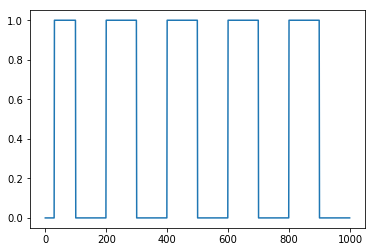

In [76]:
plt.plot(probs['filtering'][0])

# Updating predicting probabilities (needed for MSRNN)
This is needed for the MSGRU prediction

In [77]:
offset = 2*split

pp0 = probs['predictive'][0][T-1]
pp1 = probs['predictive'][1][T-1]
  
pp0s=np.array([0]*offset, dtype='float64')
pp1s=np.array([0]*offset, dtype='float64')
rs = np.array([0]*offset, dtype='float64')
    
for t in range(T,T+offset-1):
    
  #probs=e_step(vols[:t], theta)
  #pp0 = probs['predictive'][0][t-1]
  #pp1 = probs['predictive'][1][t-1]
  
  #pp0=p00*pp0 + p01*pp1
  #pp1=p10*pp0 + p11*pp1
    
  yy=data[t]
  xx=data[t-1:(t-p-1):-1]
  cpdf_0=cond_density(xx,yy,0,theta)
  cpdf_1=cond_density(xx,yy,1,theta)
  marginal=pp0*cpdf_0 + pp1*cpdf_1

  p_filter_0=pp0*cpdf_0/marginal
  p_filter_1=pp1*cpdf_1/marginal
  pp0=p00*p_filter_0 + p10*p_filter_1
  pp1=p01*p_filter_0 + p11*p_filter_1
  pp0s[t-T]=pp0
  pp1s[t-T]=pp1
    
   
  r = np.argmax([pp0,pp1])
  #print(t,r)
  rs[t-T]=r  
  #print(t, pp0,pp1, r) 
  y_hat[t+1]=(1-r)*(np.dot(theta['phi'][0:p],xx) + theta['mu'][0]) + r*(np.dot(theta['phi'][p:],xx) + theta['mu'][1]) 

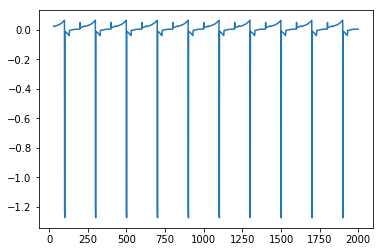

In [78]:
plt.plot(range(p,offset),y[(T+p):(T+offset)]-y_hat[(T+p):(T+offset)])

Now have generated the smoothing probabilities, we can proceed with the GRU fitting. We shall fit a basic GRU and compare the performance with our MS-GRU, which uses markov switching


# Prepare the GRUs

In [80]:
df = pd.DataFrame(data, columns=['y'])

In [81]:
use_features = ['y'] 
use_feature = 'y'
target = 'y'
n_steps = p # number of lags to include in the model (this is important)
n_units = 20


df_train = df.iloc[:split]
df_val = df.iloc[split:2*split]
df_test= df.iloc[2*split:]

In [82]:
def get_lagged_features(value, n_steps):
    lag_list = []
    for lag in range(n_steps, 0, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [83]:
x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
#y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_val_list = []
for use_feature in use_features:
    x_val_reg = get_lagged_features(df_val, n_steps).dropna()
    x_val_list.append(x_val_reg)

x_val_reg = pd.concat(x_val_list, axis=1)

x_val_reg = x_val_reg.iloc[:, col_ords]
y_val_reg = df_val.loc[x_val_reg.index, [target]].values
x_val_reg = np.reshape(x_val_reg.values, (x_val_reg.shape[0], np.int(x_val_reg.shape[1]/len(use_features)), len(use_features)))


x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps).dropna()
    x_test_list.append(x_test_reg)

x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

#y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [84]:
print(x_train_reg.shape,y_train_reg.shape,x_val_reg.shape,y_val_reg.shape,x_test_reg.shape,y_test_reg.shape)

(970, 30, 1) (970, 1) (970, 30, 1) (970, 1) (970, 30, 1) (970, 1)


# Comparsion with Keras prepackaged models (for baseline)

In [ ]:
def RNN_model():
    reg_model = Sequential()
    reg_model.add(SimpleRNN(n_units, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

In [ ]:
def GRU_model():
    reg_model = Sequential()
    reg_model.add(GRU(n_units, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

In [ ]:
def LSTM_model():
    reg_model = Sequential()
    reg_model.add(LSTM(n_units, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

In [ ]:
rnn= RNN_model()
gru= GRU_model()
lstm= LSTM_model()

rnn.summary()
gru.summary()
lstm.summary()

In [ ]:
rnn.fit(x_train_reg, y_train_reg, epochs=500, batch_size=100, verbose=1, initial_epoch = 0)

In [ ]:
gru.fit(x_train_reg, y_train_reg, epochs=500, batch_size=100, verbose=1, initial_epoch = 0)

In [ ]:
lstm.fit(x_train_reg, y_train_reg, epochs=500, batch_size=100, verbose=1, initial_epoch = 0)

In [ ]:
preds = {}

In [ ]:
preds['SimpleRNN'] ={}

In [ ]:
preds['SimpleRNN'][str(n_units)]=rnn.predict(x_test_reg, verbose=1)[:,0]

In [ ]:
preds['GRU'] ={}

In [ ]:
preds['GRU'][str(n_units)]=gru.predict(x_test_reg, verbose=1)[:,0]

In [ ]:
preds['LSTM'] ={}

In [ ]:
preds['LSTM'][str(n_units)]=lstm.predict(x_test_reg, verbose=1)[:,0]

In [ ]:

fig = plt.figure(figsize=(16,9))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="k", label="Real (Testing)")
#test_line_pred = plt.plot(df_test.index[n_steps:], preds['SimpleRNN']['1'], color="r", label="1")
test_line_pred = plt.plot(df_test.index[n_steps:], preds['SimpleRNN']['20'], color="c", label="5")
#test_line_pred = plt.plot(df_test.index[n_steps:], preds['SimpleRNN']['10'], color="g", label="10")
#test_line_pred = plt.plot(df_test.index[n_steps:], preds['GRU']['20'], color="b", label="20")
#test_line_pred = plt.plot(df_test.index[n_steps:], preds['SimpleRNN']['30'], color="y", label="30")
#test_line_pred = plt.plot(df_test.index[n_steps:], preds['SimpleRNN']['50'], color="m", label="50")

plt.legend(loc="best", fontsize=15)
plt.title('Real vs Predict (Testing)', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Volatility', fontsize=20)

plt.show()

In [ ]:
fig = plt.figure(figsize=(16,9))
idx = range(380,420)
#gru_test_err_zoom = plt.plot(df_test.index[380:420], df_test[use_feature][380:420]-pred_test[(380-n_steps):(420-n_steps),0], color="c", label="Real (Testing)")
rnn_test_err=df_test[use_feature][n_steps:]-preds['SimpleRNN'][str(n_units)][0:(T-n_steps)]
gru_test_err=df_test[use_feature][n_steps:]-preds['GRU'][str(n_units)][0:(T-n_steps)]
lstm_test_err=df_test[use_feature][n_steps:]-preds['LSTM'][str(n_units)][0:(T-n_steps)]


plt.plot(df_test.index[n_steps:], rnn_test_err,color="k", linestyle="solid", label="Simple RNN")
plt.plot(df_test.index[n_steps:], gru_test_err,color="r", linestyle="dashdot", label="GRU")
plt.plot(df_test.index[n_steps:], lstm_test_err,color="b", linestyle="dashed", label="LSTM")


plt.legend(loc="best", fontsize=15)
plt.title('Real vs Predict (Testing)', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Volatility', fontsize=20)


# MS-RNNs

In [ ]:
def RNN_model_custom(l1_reg=0.0):   
        
    input_layer = Input(shape=(x_train_reg.shape[1], x_train_reg.shape[-1])) # if there are two input dimensions, e.g. K and T
    hidden_layer = SimpleRNN(n_units, unroll=True)(input_layer)
    #Dense(n, kernel_initializer='normal', activation='tanh', kernel_regularizer=l1(l1_reg))(input_layer) # n hidden units
    out = Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg))(hidden_layer) # price is output

    weights_tensor = Input(shape=(1,)) # for loss function
    cl4 = partial(weighted_loss, weights=weights_tensor)
 
    model=Model([input_layer, weights_tensor], out)
    model.compile('adam', loss=cl4)
    return model

In [ ]:
def GRU_model_custom(l1_reg=0.0):   
        
    input_layer = Input(shape=(x_train_reg.shape[1], x_train_reg.shape[-1])) # if there are two input dimensions, e.g. K and T
    hidden_layer = GRU(n_units, unroll=True)(input_layer)
    #Dense(n, kernel_initializer='normal', activation='tanh', kernel_regularizer=l1(l1_reg))(input_layer) # n hidden units
    out = Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg))(hidden_layer) # price is output

    weights_tensor = Input(shape=(1,)) # for loss function
    cl4 = partial(weighted_loss, weights=weights_tensor)
 
    model=Model([input_layer, weights_tensor], out)
    model.compile('adam', loss=cl4)
    return model

In [ ]:
def LSTM_model_custom(l1_reg=0.0):   
        
    input_layer = Input(shape=(x_train_reg.shape[1], x_train_reg.shape[-1])) # if there are two input dimensions, e.g. K and T
    hidden_layer = LSTM(n_units, unroll=True)(input_layer)
    #Dense(n, kernel_initializer='normal', activation='tanh', kernel_regularizer=l1(l1_reg))(input_layer) # n hidden units
    out = Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg))(hidden_layer) # price is output

    weights_tensor = Input(shape=(1,)) # for loss function
    cl4 = partial(weighted_loss, weights=weights_tensor)
 
    model=Model([input_layer, weights_tensor], out)
    model.compile('adam', loss=cl4)
    return model

In [ ]:
def weighted_loss(y_true, y_pred, weights):
    return K.mean(K.square(y_true - y_pred) * weights)

In [ ]:
rnn1=RNN_model_custom()
rnn2=RNN_model_custom()

In [ ]:
rnn1.fit([x_train_reg, probs['smoothing'][0][n_steps:]], y_train_reg, epochs=500, batch_size=100, verbose=1, initial_epoch = 0)
rnn2.fit([x_train_reg, probs['smoothing'][1][n_steps:]], y_train_reg, epochs=500, batch_size=100, verbose=1, initial_epoch = 0)

In [ ]:
gru1=GRU_model_custom()
gru2=GRU_model_custom()

In [ ]:
gru1.fit([x_train_reg, probs['smoothing'][0][n_steps:]], y_train_reg, epochs=500, batch_size=100, verbose=1, initial_epoch = 0)
gru2.fit([x_train_reg, probs['smoothing'][1][n_steps:]], y_train_reg, epochs=500, batch_size=100, verbose=1, initial_epoch = 0)

In [ ]:
lstm1=LSTM_model_custom()
lstm2=LSTM_model_custom()

In [ ]:
lstm1.fit([x_train_reg, probs['smoothing'][0][n_steps:]], y_train_reg, epochs=500, batch_size=100, verbose=1, initial_epoch = 0)
lstm2.fit([x_train_reg, probs['smoothing'][1][n_steps:]], y_train_reg, epochs=500, batch_size=100, verbose=1, initial_epoch = 0)

In [ ]:
preds['MSRNN'] ={}
pred_test1 = rnn1.predict([x_test_reg,np.ones(split)[n_steps:]], verbose=1)
pred_test2 = rnn2.predict([x_test_reg,np.ones(split)[n_steps:]], verbose=1)
preds['MSRNN'][str(n_units)]=pred_test1[:,0]*(1-rs[(Tv+n_steps):(Tv+Tt)]) + pred_test2[:,0]*(rs[(n_steps+Tv):(Tv+Tt)])
#pred_test2 = reg_model2.predict([x_test_reg,pp1s[n_steps:]], verbose=1)

In [ ]:
preds['MSGRU'] ={}
pred_test1 = gru1.predict([x_test_reg,np.ones(split)[n_steps:]], verbose=1)
pred_test2 = gru2.predict([x_test_reg,np.ones(split)[n_steps:]], verbose=1)
preds['MSGRU'][str(n_units)]=pred_test1[:,0]*(1-rs[(Tv+n_steps):(Tv+Tt)]) + pred_test2[:,0]*(rs[(n_steps+Tv):(Tv+Tt)])

In [ ]:
preds['MSLSTM']={}
pred_test1 = lstm1.predict([x_test_reg,np.ones(split)[n_steps:]], verbose=1)
pred_test2 = lstm2.predict([x_test_reg,np.ones(split)[n_steps:]], verbose=1)
preds['MSLSTM'][str(n_units)]=pred_test1[:,0]*(1-rs[(Tv+n_steps):(Tv+Tt)]) + pred_test2[:,0]*(rs[(n_steps+Tv):(Tv+Tt)])

In [ ]:
fig = plt.figure(figsize=(16,9))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="b", label="$y_t$")
#test_line_pred = plt.plot(df_test.index[n_steps:], pred_test[:, 0], color="m", label="Predict (Testing)")
plt.plot(df_test.index[n_steps:], preds['SimpleRNN'][str(n_units)], color="g", linestyle="dashed", label="$\hat{y}_t$ (RNN)")
plt.plot(df_test.index[n_steps:], preds['MSRNN'][str(n_units)], color="r", linestyle="dashed", label="$\hat{y}_t$ (MSRNN)")
#plt.plot(df_test.index[n_steps:], preds['MSGRU'], color="m", label="MSGRU")
#plt.plot(df_test.index[n_steps:], preds['MSLSTM'], color="m", label="MSLSTM")

plt.plot(df_test.index[n_steps:], rs[(n_steps+Tv):(Tv+Tt)], color="k", label="$s_t$ (state)")
#plt.plot(df_test.index[n_steps:], pp0s[n_steps:], color="g", label="state")


plt.legend(loc="best", fontsize=15)
#plt.title('Real vs Predict (Testing)', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('$y_t$', fontsize=20)

plt.show()

In [ ]:
fig = plt.figure(figsize=(16,9))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="b", label="$y_t$")
#test_line_pred = plt.plot(df_test.index[n_steps:], pred_test[:, 0], color="m", label="Predict (Testing)")
plt.plot(df_test.index[n_steps:-1], preds['GRU'][str(n_units)][:-1], color="g", linestyle="dashed", label="$\hat{y}_t$ (GRU)")
plt.plot(df_test.index[n_steps:-1], preds['MSGRU'][str(n_units)][:-1], color="r", linestyle="dashed", label="$\hat{y}_t$ (MSGRU)")
#plt.plot(df_test.index[n_steps:], preds['MSGRU'], color="m", label="MSGRU")
#plt.plot(df_test.index[n_steps:], preds['MSLSTM'], color="m", label="MSLSTM")

plt.plot(df_test.index[n_steps:-1], rs[(n_steps):(T-1)], color="k", label="$s_t$ (state)")
#plt.plot(df_test.index[n_steps:], pp0s[n_steps:], color="g", label="state")


plt.legend(loc="best", fontsize=15)
#plt.title('Real vs Predict (Testing)', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('$y_t$', fontsize=20)

plt.show()

In [ ]:
fig = plt.figure(figsize=(16,9))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="b", label="$y_t$")
#test_line_pred = plt.plot(df_test.index[n_steps:], pred_test[:, 0], color="m", label="Predict (Testing)")
plt.plot(df_test.index[n_steps:-1], preds['LSTM'][str(n_units)][:-1], color="g", linestyle="dashed", label="$\hat{y}_t$ (LSTM)")
plt.plot(df_test.index[n_steps:-1], preds['MSLSTM'][str(n_units)][:-1], color="r", linestyle="dashed", label="$\hat{y}_t$ (MSLSTM)")
#plt.plot(df_test.index[n_steps:], preds['MSGRU'], color="m", label="MSGRU")
#plt.plot(df_test.index[n_steps:], preds['MSLSTM'], color="m", label="MSLSTM")

plt.plot(df_test.index[n_steps:-1], rs[(n_steps):(T-1)], color="k", label="$s_t$ (state)")
#plt.plot(df_test.index[n_steps:], pp0s[n_steps:], color="g", label="state")


plt.legend(loc="best", fontsize=15)
#plt.title('Real vs Predict (Testing)', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('$y_t$', fontsize=20)

plt.show()

In [ ]:
err = {}

In [ ]:
err['rnn'] ={}
err['rnn']['L2']={}
err['rnn']['inf']={}
rnn_test_err=df_test[use_feature][n_steps:]-preds['SimpleRNN']['1'][0:(T-n_steps)]
err['rnn']['L2']['1']=np.linalg.norm(rnn_test_err[1:-1],2)
err['rnn']['inf']['1']=np.linalg.norm(rnn_test_err[1:-1],np.inf)
rnn_test_err=df_test[use_feature][n_steps:]-preds['SimpleRNN']['5'][0:(T-n_steps)]
err['rnn']['L2']['5']=np.linalg.norm(rnn_test_err[1:-1],2)
err['rnn']['inf']['5']=np.linalg.norm(rnn_test_err[1:-1],np.inf)
rnn_test_err=df_test[use_feature][n_steps:]-preds['SimpleRNN']['10'][0:(T-n_steps)]
err['rnn']['L2']['10']=np.linalg.norm(rnn_test_err[1:-1],2)
err['rnn']['inf']['10']=np.linalg.norm(rnn_test_err[1:-1],np.inf)
rnn_test_err=df_test[use_feature][n_steps:]-preds['SimpleRNN']['20'][0:(T-n_steps)]
err['rnn']['L2']['20']=np.linalg.norm(rnn_test_err[1:-1],2)
err['rnn']['inf']['20']=np.linalg.norm(rnn_test_err[1:-1],np.inf)
rnn_test_err=df_test[use_feature][n_steps:]-preds['SimpleRNN']['30'][0:(T-n_steps)]
err['rnn']['L2']['30']=np.linalg.norm(rnn_test_err[1:-1],2)
err['rnn']['inf']['30']=np.linalg.norm(rnn_test_err[1:-1],np.inf)
rnn_test_err=df_test[use_feature][n_steps:]-preds['SimpleRNN']['50'][0:(T-n_steps)]
err['rnn']['L2']['50']=np.linalg.norm(rnn_test_err[1:-1],2)
err['rnn']['inf']['50']=np.linalg.norm(rnn_test_err[1:-1],np.inf)



In [ ]:
print(1, round(err['rnn']['L2']['1'],6), round(err['rnn']['inf']['1'],6))
print(5, round(err['rnn']['L2']['5'],6), round(err['rnn']['inf']['5'],6))
print(10, round(err['rnn']['L2']['10'],6), round(err['rnn']['inf']['10'],6))
print(20, round(err['rnn']['L2']['20'],6), round(err['rnn']['inf']['20'],6))
print(30, round(err['rnn']['L2']['30'],6), round(err['rnn']['inf']['30'],6))
print(50, round(err['rnn']['L2']['50'],6), round(err['rnn']['inf']['50'],6))

#print(round(err['gru']['L2'],6), round(err['gru']['inf'],6), round(err['msgru']['L2'], 6), round(err['msgru']['inf'],6))
#print(round(err['lstm']['L2'],6),round(err['lstm']['inf'],6), round(err['mslstm']['L2'],6), round(err['mslstm']['inf'],6))

In [ ]:
fig = plt.figure(figsize=(16,9))
#msgru_test_err = plt.plot(df_test.index[380:420], df_test[use_feature][380:420]-preds[(380-n_steps):(420-n_steps)], color="c", label="Real (Testing)")
msrnn_test_err = df_test[use_feature][n_steps:]-preds['MSRNN'][str(n_units)][:(T-n_steps)]

plt.plot(df_test.index[(n_steps+1):-1], np.abs(msrnn_test_err[1:-1]),color="b", linestyle="solid", linewidth="2",label="MSRNN")
plt.plot(df_test.index[(n_steps+1):-1], np.abs(rnn_test_err[1:-1]),color="r", linestyle="dashed", label="RNN")

#plt.plot(df_test.index[n_steps:], msgru_test_err,color="b", linestyle="dashed", label="MSGRU")
#plt.plot(df_test.index[n_steps:], mslstm_test_err,color="r", linestyle="dashdot", label="MSLSTM")

plt.legend(loc="best", fontsize=15)
#plt.title('Real vs Predict (Testing)', fontsize=20)
plt.xlabel('t', fontsize=20)
plt.ylabel('$|y_t-\hat{y}_t|$', fontsize=20)

In [ ]:
err['msrnn'] ={}
err['rnn'] ={}

err['msrnn']['L2']=np.linalg.norm(msrnn_test_err[1:-1],2)
err['msrnn']['inf']=np.linalg.norm(msrnn_test_err[1:-1],ord=np.inf)
err['rnn']['L2']=np.linalg.norm(rnn_test_err[1:-1],2)
err['rnn']['inf']=np.linalg.norm(rnn_test_err[1:-1],ord=np.inf)

In [ ]:
fig = plt.figure(figsize=(16,9))
idx = range(380,420)
#msgru_test_err = plt.plot(df_test.index[380:420], df_test[use_feature][380:420]-preds[(380-n_steps):(420-n_steps)], color="c", label="Real (Testing)")
#msrnn_test_err = df_test[use_feature][n_steps:]-preds['MSRNN'][:(T-n_steps)]
msgru_test_err = df_test[use_feature][n_steps:]-preds['MSGRU'][str(n_units)][:(T-n_steps)]
#mslstm_test_err = df_test[use_feature][n_steps:]-preds['MSLSTM'][:(T-n_steps)]

plt.plot(df_test.index[(n_steps):-1], np.abs(msgru_test_err[:-1]),color="b", linestyle="solid", linewidth="3",label="MSGRU")
plt.plot(df_test.index[(n_steps):-1], np.abs(gru_test_err[:-1]),color="r", linestyle="dashed", label="GRU")
#plt.plot(df_test.index[(n_steps):-1], np.zeros(len(df_test.index[(n_steps):-1])), color='k')
#plt.plot(df_test.index[n_steps:], msgru_test_err,color="b", linestyle="dashed", label="MSGRU")
#plt.plot(df_test.index[n_steps:], mslstm_test_err,color="r", linestyle="dashdot", label="MSLSTM")

plt.legend(loc="best", fontsize=15)
#plt.title('Real vs Predict (Testing)', fontsize=20)
plt.xlabel('t', fontsize=20)
plt.ylabel('$|y_t-\hat{y}_t|$', fontsize=20)

In [ ]:
err['msgru'] ={}
err['gru'] ={}

err['msgru']['L2']=np.linalg.norm(msgru_test_err[1:-1],2)
err['msgru']['inf']=np.linalg.norm(msgru_test_err[1:-1],ord=np.inf)
err['gru']['L2']=np.linalg.norm(gru_test_err[1:-1],2)
err['gru']['inf']=np.linalg.norm(gru_test_err[1:-1],ord=np.inf)

In [ ]:
fig = plt.figure(figsize=(16,9))
idx = range(380,420)
#msgru_test_err = plt.plot(df_test.index[380:420], df_test[use_feature][380:420]-preds[(380-n_steps):(420-n_steps)], color="c", label="Real (Testing)")
#msrnn_test_err = df_test[use_feature][n_steps:]-preds['MSRNN'][:(T-n_steps)]
#msgru_test_err = df_test[use_feature][n_steps:]-preds['MSGRU'][:(T-n_steps)]
mslstm_test_err = df_test[use_feature][n_steps:]-preds['MSLSTM'][str(n_units)][:(T-n_steps)]

plt.plot(df_test.index[(n_steps+1):-1], np.abs(mslstm_test_err[1:-1]),color="b", linestyle="solid", linewidth="3",label="MSLSTM")
plt.plot(df_test.index[(n_steps+1):-1], np.abs(lstm_test_err[1:-1]),color="r", linestyle="dashed", label="LSTM")
#plt.ylim([-0.1,0.1])
#plt.plot(df_test.index[n_steps:], msgru_test_err,color="b", linestyle="dashed", label="MSGRU")
#plt.plot(df_test.index[n_steps:], mslstm_test_err,color="r", linestyle="dashdot", label="MSLSTM")

plt.legend(loc="best", fontsize=15)
#plt.title('Real vs Predict (Testing)', fontsize=20)
plt.xlabel('t', fontsize=20)
plt.ylabel('$|y_t-\hat{y}_t|$', fontsize=20)

In [ ]:
err['mslstm'] ={}
err['lstm'] ={}

err['mslstm']['L2']=np.linalg.norm(mslstm_test_err[1:-1],2)
err['mslstm']['inf']=np.linalg.norm(mslstm_test_err[1:-1],ord=np.inf)
err['lstm']['L2']=np.linalg.norm(lstm_test_err[1:-1],2)
err['lstm']['inf']=np.linalg.norm(lstm_test_err[1:-1],ord=np.inf)

In [ ]:
print(round(err['rnn']['L2'],6), round(err['rnn']['inf'],6), round(err['msrnn']['L2'],6), round(err['msrnn']['inf'],6))
print(round(err['gru']['L2'],6), round(err['gru']['inf'],6), round(err['msgru']['L2'], 6), round(err['msgru']['inf'],6))
print(round(err['lstm']['L2'],6),round(err['lstm']['inf'],6), round(err['mslstm']['L2'],6), round(err['mslstm']['inf'],6))